# Supervised Learning Project
Beta Bank customers are leaving: little by little, chipping away every month. The bankers figured out it’s cheaper to save the existing customers rather than to attract new ones.
We need to predict whether a customer will leave the bank soon. We have the data on clients’ past behavior and termination of contracts with the bank.
In this project, we will build a model with the maximum possible F1 score. For a model to be acceptable, it should have an F1 score of at least 0.59. 
Additionally, we will measure the AUC-ROC metric and compare it with the F1.

## Preprocessing
Our dataset consists of:  
**Features**
- `RowNumber` — data string index
- `CustomerId` — unique customer identifier
- `Surname` — surname
- `CreditScore` — credit score
- `Geography` — country of residence
- `Gender` — gender
- `Age` — age
- `Tenure` — period of maturation for a customer’s fixed deposit (years)
- `Balance` — account balance
- `NumOfProducts` — number of banking products used by the customer
- `HasCrCard` — customer has a credit card
- `IsActiveMember` — customer’s activeness
- `EstimatedSalary` — estimated salary

**Target**
- `Exited` — сustomer has left

In [30]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
from sklearn.utils import shuffle
from matplotlib import pyplot as plt
import seaborn as sns
import warnings

In [2]:
try:
    df = pd.read_csv('Churn.csv')
except FileNotFoundError:
    df = pd.read_csv('/datasets/Churn.csv')

In [3]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [5]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
RowNumber,10000.0,NaN,NaN,NaN,5000.5,2886.89568,1.0,2500.75,5000.5,7500.25,10000.0
CustomerId,10000.0,NaN,NaN,NaN,15690940.5694,71936.186123,15565701.0,15628528.25,15690738.0,15753233.75,15815690.0
Surname,10000,2932,Smith,32,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CreditScore,10000.0,NaN,NaN,NaN,650.5288,96.653299,350.0,584.0,652.0,718.0,850.0
Geography,10000,3,France,5014,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gender,10000,2,Male,5457,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,10000.0,NaN,NaN,NaN,38.9218,10.487806,18.0,32.0,37.0,44.0,92.0
Tenure,9091.0,NaN,NaN,NaN,4.99769,2.894723,0.0,2.0,5.0,7.0,10.0
Balance,10000.0,NaN,NaN,NaN,76485.889288,62397.405202,0.0,0.0,97198.54,127644.24,250898.09
NumOfProducts,10000.0,NaN,NaN,NaN,1.5302,0.581654,1.0,1.0,1.0,2.0,4.0


Check for duplicates.

In [6]:
df.duplicated().sum()

0

There are missing values in `Tenure`, so we'll look at the distribution of existing values and pick a value for filling the blanks.

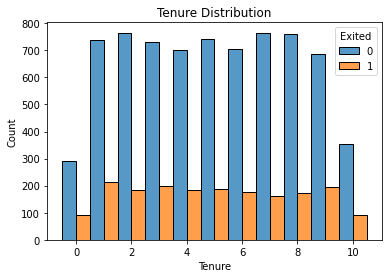

Mean: 4.997690023099769
Median: 5.0


In [7]:
sns.histplot(df, x='Tenure', hue='Exited', discrete=True, multiple='dodge')
plt.title('Tenure Distribution')
plt.show()

print('Mean: {}\nMedian: {}'.format(df['Tenure'].mean(), df['Tenure'].median()))

Mean and median are the same, so either is fine. We can also notice that these are integers stored as floats and fix this.

In [8]:
df['Tenure'] = df['Tenure'].fillna(df['Tenure'].median()).astype('int')

3 columns are irrelevant: `RowNumber`, `CostumerId` and `Surname`. Keeping them will only add noise.

In [9]:
df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

Reduce dataset size.

In [10]:
for column in df.columns:
    if df[column].dtype == 'float64':
        df[column] = df[column].astype('float32')
    elif df[column].dtype == 'int64':
        df[column] = df[column].astype('int32')

Apply one-hot encoding.

In [11]:
df = pd.get_dummies(df, drop_first=True)

Create a 6-2-2 train-validation-test split.

In [12]:
x, y = df.drop('Exited', axis=1), df['Exited']
x_trva, x_test, y_trva, y_test = train_test_split(x, y, random_state=42069, test_size=0.2)
x_train, x_valid, y_train, y_valid = train_test_split(x_trva, y_trva, random_state=42069, test_size=0.25)
pd.Series([y_train.count(), y_valid.count(), y_test.count()], index=['train', 'valid', 'test'])/y.count()

train    0.6
valid    0.2
test     0.2
dtype: float64

Scale all numeric features.

In [13]:
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

scaler = StandardScaler()
scaler.fit(x_train[numeric])

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    x_train[numeric] = scaler.transform(x_train[numeric])
    x_valid[numeric] = scaler.transform(x_valid[numeric])
    x_trva[numeric] = scaler.transform(x_trva[numeric])
    x_test[numeric] = scaler.transform(x_test[numeric])

## Without Balancing
To set a benchmark, we will evaluate a decision tree model without any balancing.

In [45]:
model = DecisionTreeClassifier(random_state=42069)
model.fit(x_train, y_train)
print('F1 = {}\nROC-AUC = {}'.format(
    f1_score(y_valid, model.predict(x_valid)), 
    roc_auc_score(y_valid, model.predict_proba(x_valid)[:, 1])
))

F1 = 0.5043695380774033
ROC-AUC = 0.6929028692852992


## Balance by Upsampling
The first method of balancing to examine will be upsampling. We will duplicate the more sparse features-target combinations so that they are roughly as common as the other option. We know from reviewing the data that the mean of `Exited` is 0.2, so the ratio of ones to zeros is about 1 to 4.

In [15]:
def upsample(x, y, ratio, random_state=None):
    x_zeros = x[y == 0]
    x_ones = x[y == 1]
    y_zeros = y[y == 0]
    y_ones = y[y == 1]

    x_upsampled = pd.concat([x_zeros] + [x_ones] * ratio)
    y_upsampled = pd.concat([y_zeros] + [y_ones] * ratio)

    x_upsampled, y_upsampled = shuffle(x_upsampled, y_upsampled, random_state=random_state)

    return x_upsampled, y_upsampled

In [16]:
x_ups, y_ups = upsample(x_train, y_train, 4, random_state=42069)

In [44]:
model = DecisionTreeClassifier(random_state=42069)
model.fit(x_ups, y_ups)
print('F1 = {}\nROC-AUC = {}'.format(
    f1_score(y_valid, model.predict(x_valid)), 
    roc_auc_score(y_valid, model.predict_proba(x_valid)[:, 1])
))

F1 = 0.5051282051282052
ROC-AUC = 0.6915197664163305


There is an improvement in F1 score, but a worse ROC-AUC score.

## Balance by Weights
By assigning a balanced class weight, we assure that both options have an identical total weight.

In [43]:
model = DecisionTreeClassifier(random_state=42069, class_weight='balanced')
model.fit(x_train, y_train)
print('F1 = {}\nROC-AUC = {}'.format(
    f1_score(y_valid, model.predict(x_valid)), 
    roc_auc_score(y_valid, model.predict_proba(x_valid)[:, 1])
))

F1 = 0.5090439276485789
ROC-AUC = 0.6933865990236734


It performed better than the previous approaches in both F1 and ROC-AUC scores. It was also less cumbersome than upsampling coding-wise. 

## Hyperparameter Optimization
Now that we know that balancing by weights gave us better results, we will try to find the best random forest model by looping through hyperparameters and keeping the set that produced the model with the highest F1 score.

In [25]:
default_depth = model.get_depth()

In [46]:
best_forest = {'f1': 0}

for depth in range(10, default_depth+1, 2):
    for split in range(10, 31, 10):
        for n in range(100, 201, 25):
            forest_model = RandomForestClassifier(
                random_state=42069, 
                n_estimators=n, 
                max_depth=depth, 
                min_samples_split=split,
                class_weight='balanced'
            )
            forest_model.fit(x_train, y_train)
            f1 = f1_score(y_valid, forest_model.predict(x_valid))
            if f1 > best_forest['f1']:
                (best_forest['n_estimators'], best_forest['max_depth'], 
                 best_forest['f1'], 
                 best_forest['min_samples_split'], best_forest['roc_auc'],
                ) = (n, depth, f1, split, roc_auc_score(y_valid, model.predict_proba(x_valid)[:, 1]))
                print(best_forest)

print('finished')

{'f1': 0.610576923076923, 'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 10, 'roc_auc': 0.6929028692852992}
{'f1': 0.6177884615384615, 'n_estimators': 125, 'max_depth': 10, 'min_samples_split': 10, 'roc_auc': 0.6929028692852992}
{'f1': 0.6225961538461537, 'n_estimators': 150, 'max_depth': 10, 'min_samples_split': 10, 'roc_auc': 0.6929028692852992}
{'f1': 0.6246913580246914, 'n_estimators': 150, 'max_depth': 16, 'min_samples_split': 20, 'roc_auc': 0.6929028692852992}
finished


The best option is to limit the depth, ie number of levels, in each tree, as well as the minimal number of samples for a split, because if the model is too complicated it will learn noise to a degree that will reduce its performance. Same argument goes for the number of trees in the forest.

## Final Testing
For the final testing, we will plug the hyperparameters from the last section to the final model, train it on both train and validation data, and test it on the test data.

In [47]:
final_model = RandomForestClassifier(
    random_state=42069, 
    n_estimators=best_forest['n_estimators'], 
    max_depth=best_forest['max_depth'],
    min_samples_split=best_forest['min_samples_split'],
    class_weight='balanced',
)
final_model.fit(x_trva, y_trva)
print('F1 = {}\nROC-AUC = {}'.format(
    f1_score(y_test, final_model.predict(x_test)), 
    roc_auc_score(y_test, final_model.predict_proba(x_test)[:, 1])
))

F1 = 0.6141176470588235
ROC-AUC = 0.8540168644222775


The F1 score is higher than the 0.59 goal we have set for ourselves, and a ROC-AUC of 0.85 is also very nice.

In [23]:
(f1_score(y_valid, model.predict(x_valid))/0.59-1)*100

4.0877367896311245

We have exceeded the goal by 4%. Following is the ROC curve, visualising how good our ROC-AUC is.

In [32]:
fpr, tpr, thresholds = roc_curve(y_test, final_model.predict_proba(x_test)[:, 1])

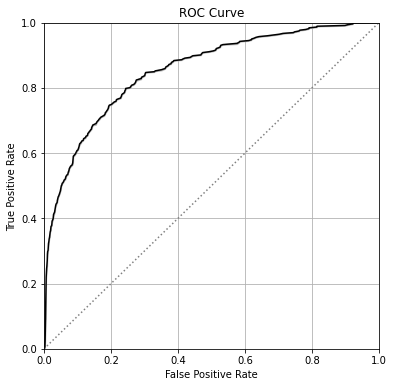

In [39]:
plt.figure(figsize=(6,6))
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
sns.lineplot(x=fpr, y=tpr, color='black')
sns.lineplot(x=[0,1], y=[0,1], linestyle=':', color='grey')
plt.xlim(0,1)
plt.ylim(0,1)
plt.grid()
plt.show()

The details of the final model are shown below.

In [26]:
final_model

RandomForestClassifier(class_weight='balanced', max_depth=16,
                       min_samples_split=20, n_estimators=150,
                       random_state=42069)